In [1]:
# import relevant modules
import numpy as np
from src.dynamical_systems.prednisone_3D import Prednisone3D
from src.sampler import Sampler
from src.density_estimator import DensityEstimator
import src.utility as utility
import matplotlib.pyplot as plt

# set random seed
np.random.seed(0)

## Data generation and visualization

In [2]:
# generate data set and visualize

model = Prednisone3D()

gen_data_opts = {
    'num_examples': np.array([40, 40]),                      # Array with number of examples per class
    'init_cond': np.array([0, 0]),                           # Array holding intial condition for prednisone model (P0: prednisone in blood, L0: prednisolone in blood)
    't_lim': np.array([0, 240]),                             # Array holding minimal and maximal time values t_min and t_max
    'obs_regularity': np.array([10, 15]),                    # Array holding the minimum and maximum amount of time steps between t_min and t_max
    'obs_noise_cov': np.diag([20, 20]),                      # Array holding the cov. matrix for observational noise to be added to P and L trajectories
    'scale_spiral': 0.15,                                    # Number giving the scaling of the sprial structure that characterizes the class-conditionals
    'sigma_orth_comp': 0.05,                                 # Positive Number, giving the std. of Gaussian components orthogonal to spiral
    'shift_vec': np.array([0.1, 0.1, 0.1]),                  # Array giving the shift of the spiral center 
    'rot_angles': [-np.pi / 4, 0., 0.]                       # List containing the x, y and z rotation angles
}

data_box_t = model.gen_timeseries_data_rotated_spiral(gen_data_opts)

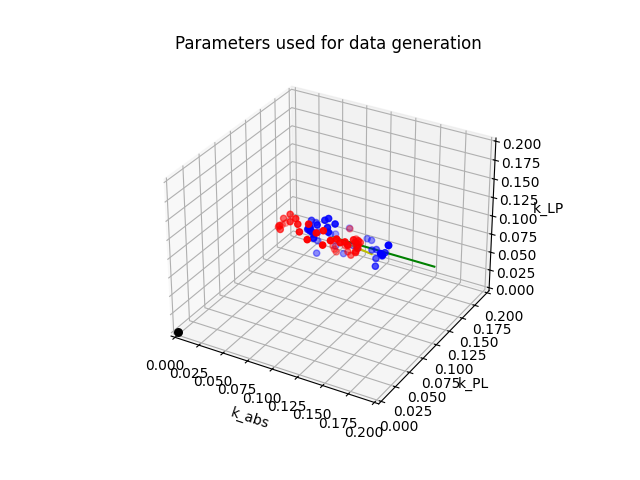

In [3]:
# get labels and class indices
labels = data_box_t.get_labels()
idx_C0 = [idx for idx, value in enumerate(labels) if value == 0]
idx_C1 = [idx for idx, value in enumerate(labels) if value == 1]

# get parameters and separate by class
parameters = data_box_t.get_parameters()
params_C0 = parameters[idx_C0, :]
params_C1 = parameters[idx_C1, :]

# get true subspace
subspace = data_box_t.get_subspace()
center = subspace['center']
v1 = 0.1 * subspace['v1']
v2 = 0.1 * subspace['v2']

# visualize the groundtruth parameters
%matplotlib widget 

# create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(params_C0[:, 0], params_C0[:, 1], params_C0[:, 2], c='blue')
ax.scatter(params_C1[:, 0], params_C1[:, 1], params_C1[:, 2], c='red')

ax.plot([center[0], center[0] + v1[0]], [center[1], center[1] + v1[1]], zs=[center[2], center[2] + v1[2]], color='g')
ax.plot([center[0], center[0] + v2[0]], [center[1], center[1] + v2[1]], zs=[center[2], center[2] + v2[2]], color='y')

ax.scatter(0, 0, 0, color='k', linewidths=2)

ax.set_xlim([0, 0.2])
ax.set_ylim([0, 0.2])
ax.set_zlim([0, 0.2])

ax.set_xlabel('k_abs')
ax.set_ylabel('k_PL')
ax.set_zlabel('k_LP')
ax.set_title('Parameters used for data generation')

plt.show()

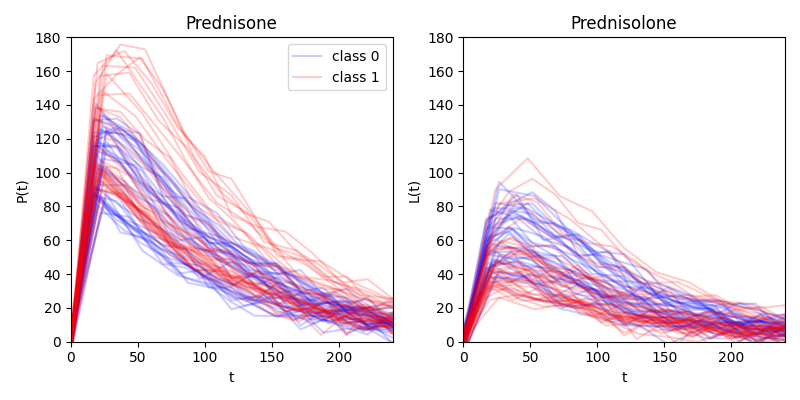

In [4]:
# plot generated time series data

timeseries = data_box_t.get_timeseries()

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

for i in range(len(idx_C0)):
    if i == 0:
        label = label='class 0'
    else:
        label = None
    axs[0].plot(timeseries[idx_C0[i]][0, :], timeseries[idx_C0[i]][1, :], color='blue', alpha=0.2, label=label)
    axs[1].plot(timeseries[idx_C0[i]][0, :], timeseries[idx_C0[i]][2, :], color='blue', alpha=0.2)


for i in range(len(idx_C1)):
    if i == 0:
        label = label='class 1'
    else:
        label = None
    axs[0].plot(timeseries[idx_C1[i]][0, :], timeseries[idx_C1[i]][1, :], color='red', alpha=0.2, label=label)
    axs[1].plot(timeseries[idx_C1[i]][0, :], timeseries[idx_C1[i]][2, :], color='red', alpha=0.2)


axs[0].set_xlabel('t')
axs[0].set_ylabel('P(t)')
axs[0].set_xlim(0, 240)
axs[0].set_ylim(0, 180)
axs[0].set_title('Prednisone')
axs[0].legend()

axs[1].set_xlabel('t')
axs[1].set_ylabel('L(t)')
axs[1].set_xlim(0, 240)
axs[1].set_ylim(0, 180)
axs[1].set_title('Prednisolone')


plt.tight_layout()
plt.show()


## Sampling

In [ ]:
# define sampler and run

# set sampler options
sampler_opts = {
    'type': 'nested_sampling',
    'num_live_points': 50,
    'parallel': True,
    'num_CPU': 8,
    'weighted': False
}

# define sampler object
sampler = Sampler(data_box_t, sampler_opts)

# run sampling
data_box_ts = sampler.run_sampling()

In [ ]:
# visualize created samples

num_bins = 100
smoothness = 1
colours = ['blue', 'red', 'green']
labels=[r"$m_{1}$",
        r"$m_{2}$",
        r"$s_{1}$",
        r"$s_{2}$"]
limits = np.array([[0, 100],
                   [0, 100],
                   [-1, 1],
                   [-1, 1],])

title = 'Gravitational Waves'
legend = ['NS - BH / NS - NS', 'Small BH - Small BH', 'Large BH - Large BH ']
figsize = (15, 6)

figure = data_box_ts.plot_posterior_samples(
                                            num_bins = 100, 
                                            smoothness = 1, 
                                            colours = ['blue', 'red'],
                                            labels=[r"$k_{abs}$", r"$k_{PL}$", r"$k_{LP}$"], 
                                            limits=np.array([[0, 0.2],
                                                             [0, 0.2],
                                                             [0, 0.2]]), 
                                            title='Samples', 
                                            legend=['class 0', 'class 1'], 
                                            figsize=(10, 10)
                                            )

## Density Estimation

In [ ]:
# create density estimates with spherical covariance structure

# set density estimation options
density_est_opts = {
    'type':             'bayesian_gaussian_mixture',
    'covariance_type':                  'spherical',    # 'full', 'diag' 'spherical' 
    'n_components':                               5,    # 20 
    'n_init' :                                   20,    # 20
    'max_iter':                                 500,    # 500
    'trim_percent':                            0.99
}

# define density estimator object
dens_estimator = DensityEstimator(data_box_ts, density_est_opts)

# run density estimation
data_box_spherical = dens_estimator.run_density_estimation()

In [ ]:
# create density estimates with full covariance structure

# set density estimation options
density_est_opts = {
    'type':             'bayesian_gaussian_mixture',
    'covariance_type':                       'full',    # 'full', 'diag' 'spherical' 
    'n_components':                               5,    # 20
    'n_init' :                                   20,    # 20
    'max_iter':                                 500,    # 500
    'trim_percent':                            0.99
}

# define density estimator object
dens_estimator = DensityEstimator(data_box_ts, density_est_opts)

# run sampling
data_box_full = dens_estimator.run_density_estimation()

In [ ]:
# visualize density estimates
plot_opts = {
'x_lim':        np.array([0, 0.2]),
'y_lim':        np.array([0, 0.2]),
'z_lim':        np.array([0, 0.2]),
'x_label':      'k_ex',
'y_label':      'k_PL',
'z_label':      'k_LP'
}

utility.plot_spirals(data_box_spherical, plot_opts)

## Save data to file

In [15]:
# save data boxes with created density estimates
data_box_spherical.save_data('spherical_finite_mixture_5_components')
data_box_full.save_data('full_finite_mixture_5_components')